# Brazilian Investment Company Registration Study
### Udacity Data Engineering Capstone Project

#### Project Summary
The Brazilian Securities Commission (CVM) was created on 12/07/1976 by Law 6,385/76, with the objective of inspecting, regulating, disciplining and developing the securities market in Brazil. And it makes public data available at the following address: http://dados.cvm.gov.br/organization/cvm

The Brazilian Open Data Portal (https://dados.gov.br/) is the tool provided by the government so that everyone can find and use public data and information.

This project aims to understand how open capital companies are distributed in Brazil.

The project follows the follow steps:
* **Step 1**: Scope the Project and Gather Data
* **Step 2**: Explore and Assess the Data
* **Step 3**: Define the Data Model
* **Step 4**: Run ETL to Model the Data
* **Step 5**: Complete Project Write Up

In [20]:
# !pip install pandas pyspark numpy scipy requests matplotlib

In [35]:
%load_ext autoreload
# %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%%html
<style>
table {float:left}
</style>

In [4]:
# All imports and installs
import pandas as pd
import requests
import json
from lxml import html
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType, TimestampType
import plotly.express as px

### Step 1: Scope the Project and Gather Data

#### Scope 
This project shows how open capital companies are distributed by State, City, Activity Sector, and Shareholding Control Type

#### Describe and Gather Data 
The data used in this project contains information from Brazilian open capital companies, and is available on the PORTAL BRASILEIRO DE DADOS ABERTOS (http://dados.cvm.gov.br/dataset/cia_aberta-cad) along with a data dictionary that has been saved in the `data` directory of this project.

All data come in Brazilian Portuguese, and I share below the translated name of used fields:

* **CNPJ_CIA**: Company Document
* **CD_CVM**: Company ID on CVM
* **DENOM_SOCIAL**: Social denomination / Company business name
* **DENOM_COMERC**: Comercial denomination / Company comercial name
* **DT_REG**: Registration Date
* **SIT**: Status / Situation
* **SETOR_ATIV**: Activity Sector
* **CONTROLE_ACIONARIO**: Shareholding control type
* **UF**: State
* **MUN**: City

* **{*}_RESP**: Responsible person fields, eg.: UF_RESP: State of responsible person

Other important translations:

* **ATIVO**: Active
* **CENCELADA**: Cencelled


---
    **IMPORTANT!** if you overwrite files, downloading from original source, you will need to convert files to UTF8 encoding. Use the follow command on shell:

```sh
iconv -f WINDOWS-1252 -t UTF-8 meta_cad_cia_aberta.txt > meta_cad_cia_aberta.tmp.txt && mv -f meta_cad_cia_aberta.tmp.txt meta_cad_cia_aberta.txt
iconv -f WINDOWS-1252 -t UTF-8 cad_cia_aberta.csv > cad_cia_aberta.tmp.csv && mv -f cad_cia_aberta.tmp.csv cad_cia_aberta.csv
```
---

In [6]:
# Starting Spark
spark = SparkSession\
    .builder\
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0")\
    .getOrCreate()

In [3]:
# Reading data
dataset_schema = StructType([
    StructField("CNPJ_CIA", StringType()),
    StructField("DENOM_SOCIAL", StringType()),
    StructField("DENOM_COMERC", StringType()),
    StructField("DT_REG", DateType()),
    StructField("DT_CONST", DateType()),
    StructField("DT_CANCEL", DateType()),
    StructField("MOTIVO_CANCEL", StringType()),
    StructField("SIT", StringType()),
    StructField("DT_INI_SIT", DateType()),
    StructField("CD_CVM", IntegerType()),
    StructField("SETOR_ATIV", StringType()),
    StructField("TP_MERC", StringType()),
    StructField("CATEG_REG", StringType()),
    StructField("DT_INI_CATEG", StringType()),
    StructField("SIT_EMISSOR", StringType()),
    StructField("DT_INI_SIT_EMISSOR", DateType()),
    StructField("CONTROLE_ACIONARIO", StringType()),
    StructField("TP_ENDER", StringType()),
    StructField("LOGRADOURO", StringType()),
    StructField("COMPL", StringType()),
    StructField("BAIRRO", StringType()),
    StructField("MUN", StringType()),
    StructField("UF", StringType()),
    StructField("PAIS", StringType()),
    StructField("CEP", IntegerType()),
    StructField("DDD_TEL", IntegerType()),
    StructField("TEL", StringType()),
    StructField("DDD_FAX", IntegerType()),
    StructField("FAX", IntegerType()),
    StructField("EMAIL", StringType()),
    StructField("TP_RESP", StringType()),
    StructField("RESP", StringType()),
    StructField("DT_INI_RESP", DateType()),
    StructField("LOGRADOURO_RESP", StringType()),
    StructField("COMPL_RESP", StringType()),
    StructField("BAIRRO_RESP", StringType()),
    StructField("MUN_RESP", StringType()),
    StructField("UF_RESP", StringType()),
    StructField("PAIS_RESP", StringType()),
    StructField("CEP_RESP", StringType()),
    StructField("DDD_TEL_RESP", IntegerType()),
    StructField("TEL_RESP", IntegerType()),
    StructField("DDD_FAX_RESP", IntegerType()),
    StructField("FAX_RESP", IntegerType()),
    StructField("EMAIL_RESP", StringType()),
    StructField("CNPJ_AUDITOR", StringType()),
    StructField("AUDITOR", StringType())
])

df_spark = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=';'
).csv("./data/cad_cia_aberta.csv", schema=dataset_schema)

In [4]:
df_spark.toPandas().head()

,CNPJ_CIA,DENOM_SOCIAL,DENOM_COMERC,DT_REG,DT_CONST,DT_CANCEL,MOTIVO_CANCEL,SIT,DT_INI_SIT,CD_CVM,...,UF_RESP,PAIS_RESP,CEP_RESP,DDD_TEL_RESP,TEL_RESP,DDD_FAX_RESP,FAX_RESP,EMAIL_RESP,CNPJ_AUDITOR,AUDITOR
0,08.773.135/0001-00,2W ENERGIA S.A.,None,2020-10-29,2007-03-23,None,None,ATIVO,2020-10-29,25224,...,SP,None,4707000,11.0,39579400.0,11.0,39579499.0,ri@2wenergia.com.br,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S
1,11.396.633/0001-87,3A COMPANHIA SECURITIZADORA,TRIPLO A COMPANHIA SECURITIZADORA,2010-03-08,2009-11-03,2015-12-18,Cancelamento Voluntário - IN CVM 480/09,CANCELADA,2015-12-18,21954,...,RJ,None,20020000,21.0,22338867.0,21.0,22338867.0,juridico@triploasec.com.br,60.525.706/0001-07,MOORE STEPHENS LIMA LUCCHESI AUDITORES INDEPEN...
2,12.091.809/0001-55,3R PETROLEUM OLÉO E GÁS S.A.,None,2020-11-09,2010-06-08,None,None,ATIVO,2020-11-09,25291,...,RJ,None,22250180,21.0,21455555.0,0.0,0.0,ri@3rpetroleum.com.br,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES
3,01.547.749/0001-16,521 PARTICIPAÇOES S.A. - EM LIQUIDAÇÃO EXTRAJU...,521 PARTICIPAÇÕES S/A,1997-07-11,1996-07-30,None,None,ATIVO,1997-07-11,16330,...,None,None,None,NaN,NaN,NaN,NaN,None,10.830.108/0001-65,GRANT THORNTON AUDITORES INDEPENDENTES
4,01.851.771/0001-55,524 PARTICIPAÇOES SA,524 PARTICIPACOES SA,1997-05-30,1997-04-02,None,None,ATIVO,1997-05-30,16284,...,RJ,None,20030021,21.0,38043700.0,21.0,38043480.0,gar@opportunity.com.br,10.830.108/0001-65,GRANT THORNTON AUDITORES INDEPENDENTES


In [46]:
# df_spark.printSchema()

In [5]:
# Write to parquet
df_spark.write.parquet("./data/parquet/br_open_cias_data", mode="overwrite")
df_spark=spark.read.parquet("./data/parquet/br_open_cias_data")

### Step 2: Explore and Assess the Data

#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

In [6]:
# Create temp view
df_spark.createOrReplaceTempView("br_open_cias_dataset")

In [7]:
##### Verify general missing values
missing_values = spark.sql("""
    SELECT 
        COUNT(1) - COUNT(CNPJ_CIA) as MISSING_CNPJ_CIA,
        COUNT(1) - COUNT(CD_CVM) as MISSING_CD_CVM,
        COUNT(1) - COUNT(DENOM_SOCIAL) as MISSING_DENOM_SOCIAL,
        COUNT(1) - COUNT(DENOM_COMERC) as MISSING_DENOM_COMERC,
        COUNT(1) - COUNT(DT_REG) as MISSING_DT_REG,
        COUNT(1) - COUNT(SIT) as MISSING_SIT,
        COUNT(1) - COUNT(SETOR_ATIV) as MISSING_SETOR_ATIV,
        COUNT(1) - COUNT(CONTROLE_ACIONARIO) as MISSING_CONTROLE_ACIONARIO,
        COUNT(1) - COUNT(UF) as MISSING_UF,
        COUNT(1) - COUNT(MUN) as MISSING_MUN
    FROM br_open_cias_dataset
""")
missing_values.toPandas().transpose()

,0
MISSING_CNPJ_CIA,0
MISSING_CD_CVM,0
MISSING_DENOM_SOCIAL,0
MISSING_DENOM_COMERC,54
MISSING_DT_REG,0
MISSING_SIT,0
MISSING_SETOR_ATIV,6
MISSING_CONTROLE_ACIONARIO,0
MISSING_UF,1
MISSING_MUN,39


In [8]:
##### Verify duplications
duplicated_values = spark.sql("""
    SELECT 
        COUNT(CNPJ_CIA) - COUNT(DISTINCT CNPJ_CIA) - 1 as DUPLICATED_CNPJ_CIA,
        COUNT(CD_CVM) - COUNT(DISTINCT CD_CVM) - 1 as DUPLICATED_CD_CVM,
        COUNT(DENOM_SOCIAL) - COUNT(DISTINCT DENOM_SOCIAL) - 1 as DUPLICATED_DENOM_SOCIAL,
        COUNT(DENOM_COMERC) - COUNT(DISTINCT DENOM_COMERC) - 1 as DUPLICATED_DENOM_COMERC,
        COUNT(DT_REG) - COUNT(DISTINCT DT_REG) - 1 as DUPLICATED_DT_REG,
        COUNT(SIT) - COUNT(DISTINCT SIT) - 1 as DUPLICATED_SIT,
        COUNT(SETOR_ATIV) - COUNT(DISTINCT SETOR_ATIV) - 1 as DUPLICATED_SETOR_ATIV,
        COUNT(CONTROLE_ACIONARIO) - COUNT(DISTINCT CONTROLE_ACIONARIO) - 1 as DUPLICATED_CONTROLE_ACIONARIO,
        COUNT(UF) - COUNT(DISTINCT UF) - 1 as DUPLICATED_UF,
        COUNT(MUN) - COUNT(DISTINCT MUN) - 1 as DUPLICATED_MUN
    FROM br_open_cias_dataset
    WHERE SIT = 'ATIVO'
""")
duplicated_values.toPandas().transpose()

,0
DUPLICATED_CNPJ_CIA,0
DUPLICATED_CD_CVM,0
DUPLICATED_DENOM_SOCIAL,0
DUPLICATED_DENOM_COMERC,0
DUPLICATED_DT_REG,107
DUPLICATED_SIT,674
DUPLICATED_SETOR_ATIV,619
DUPLICATED_CONTROLE_ACIONARIO,669
DUPLICATED_UF,653
DUPLICATED_MUN,527


### There's no relevant duplications or missing values

Based on identifyers fields `CNPJ`, adn `CD_CVM`, there's no relevant duplications or missing values

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

![Conceptual Data Model](./docs/img/dim_model.png)


#### 3.2 Mapping Out Data Pipelines

The project follows the follow steps to mapping data into conveptual data model:
* **Step 1**: Extract and transform companies data, load to `dim_company` table, and save parquet file
* **Step 2**: Extract and transform companies location data, load into `dim_location` table, and save parquet file
* **Step 3**: Extract and transform CVM registration data from csv file and company location id from `dim_location`, load into `fact_company_registration` table, and save parquet file
* **Step 4**: Extract and transform registration dates from `fact_company_registration` table, load into `dim_time` table, and save parquet file


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [9]:
# Step 1 - dim_company
open_cias = spark.read.parquet("./data/parquet/br_open_cias_data")
open_cias.createOrReplaceTempView("open_cias")
dim_company = spark.sql("""
    SELECT 
        CNPJ_CIA as cnpj,
        DENOM_SOCIAL as company_name,
        DENOM_COMERC as business_name,
        SETOR_ATIV as sector,
        CONTROLE_ACIONARIO as control_type,
        UF as state,
        MUN as city,
        BAIRRO as neighborhood
    FROM open_cias
    WHERE SIT = 'ATIVO'
""").dropDuplicates()
dim_company.createOrReplaceTempView("dim_company")
dim_company.write.parquet('./data/parquet/dim_company', mode="overwrite")

dim_company.toPandas().head()

,cnpj,company_name,business_name,sector,control_type,state,city,neighborhood
0,19.526.748/0001-50,COMPANHIA INDUSTRIAL CATAGUASES,COMPANHIA INDUSTRIAL CATAGUASES,Têxtil e Vestuário,PRIVADO,MG,CATAGUASES,VILA TEREZA
1,28.201.130/0001-01,ENERGISA TRANSMISSÃO DE ENERGIA S.A.,ENERGISA TRANSMISSÃO DE ENERGIA S.A.,Emp. Adm. Part. - Energia Elétrica,PRIVADO,MG,CATAGUASES,CENTRO
2,12.979.898/0001-70,FORTE SECURITIZADORA S.A.,FORTE SECURITIZADORA S/A,Securitização de Recebíveis,PRIVADO,SP,SÃO PAULO,VILA OLíMPIA
3,92.012.467/0001-70,GRAZZIOTIN SA,GRAZZIOTIN,Comércio (Atacado e Varejo),PRIVADO,RS,None,SÃO CRISTOVAO
4,10.240.186/0001-00,LINHAS DE XINGU TRANSMISSORA DE ENERGIA S.A.,LINHAS DE XINGU TRANSMISSORA DE ENERGIA S.A.,Energia Elétrica,PRIVADO,RJ,RIO DE JANEIRO,Centro


In [10]:
# Step 2 - dim_location
spec = Window.partitionBy().orderBy(["state", "city", "neighborhood"])
dim_location = spark.sql("""
    SELECT DISTINCT
        state,
        city,
        neighborhood
    FROM dim_company
""").withColumn("location_id", F.row_number().over(spec)).dropDuplicates()
dim_location.createOrReplaceTempView("dim_location")
dim_location.write.parquet('./data/parquet/dim_location', mode="overwrite")

dim_location.toPandas().head()

,state,city,neighborhood,location_id
0,AM,MANAUS,DISTRITO INDUSTRIAL,1
1,BA,None,COPEC,2
2,BA,None,Copec,3
3,BA,None,Santiago,4
4,BA,None,Àrea Indl. Leste,5


In [12]:
# Step 3 - fact_company_registration
fact_company_registration = spark.sql("""
    SELECT DISTINCT
        c.CD_CVM as cvm_id,
        c.SETOR_ATIV as sector,
        c.CNPJ_CIA as cnpj,
        c.DT_REG as registration_date,
        l.location_id
    FROM open_cias c
    JOIN dim_location l ON (l.state = c.UF
        AND l.city = c.MUN
        AND l.neighborhood = c.BAIRRO
    )
    WHERE SIT = 'ATIVO'
""").dropDuplicates()
fact_company_registration.createOrReplaceTempView("fact_company_registration")
fact_company_registration.write.parquet('./data/parquet/fact_company_registration', mode="overwrite")

fact_company_registration.toPandas().head()

,cvm_id,sector,cnpj,registration_date,location_id
0,1597,Emp. Adm. Part. - Sem Setor Principal,14.308.514/0001-13,1983-12-12,14
1,8451,"Máquinas, Equipamentos, Veículos e Peças",88.611.835/0001-29,1977-07-20,193
2,9393,Metalurgia e Siderurgia,60.398.369/0004-79,1977-07-20,8
3,23590,Seguradoras e Corretoras,42.278.473/0001-03,2015-05-11,32
4,18821,Emp. Adm. Part. - Serviços Transporte e Logística,02.846.056/0001-97,2000-12-19,407


In [13]:
# Step 4 - dim_time
dim_time = spark.sql("""
    SELECT 
      DISTINCT registration_date,
      YEAR(registration_date) as year,
      MONTH(registration_date) as month,
      DAY(registration_date) as day,
      WEEKDAY(registration_date) as weekday,
      QUARTER(registration_date) as quarter
    FROM fact_company_registration
""").dropDuplicates()
dim_time.createOrReplaceTempView("dim_time")
dim_time.write.parquet('./data/parquet/dim_time', mode="overwrite")

dim_time.toPandas().head()

,registration_date,year,month,day,weekday,quarter
0,1995-02-21,1995,2,21,1,1
1,2016-02-19,2016,2,19,4,1
2,2010-09-20,2010,9,20,0,3
3,1971-12-08,1971,12,8,2,4
4,1980-09-03,1980,9,3,2,3


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [75]:
# Perform fact_company_registration quality checks
dq_fact_company_registration = spark.sql("""
    SELECT COUNT(*) 
    FROM fact_company_registration
    WHERE cvm_id IS NULL
""")
dq_fact_company_registration.toPandas()

,count(1)
0,0


In [79]:
# Perform dim_location quality checks 
dq_dim_location = spark.sql("""
    SELECT COUNT(*)
    FROM dim_location
    WHERE location_id IS NULL
""")
dq_dim_location.toPandas()

,count(1)
0,0


In [12]:
# Perform dim_time quality checks 
dq_dim_time = spark.sql("""
    SELECT COUNT(*)
    FROM dim_time
    WHERE registration_date IS NULL
""")
dq_dim_time.toPandas()

,count(1)
0,0


#### 4.3 Expoloring Data 

Explore from mapped data

In [7]:
# Reading data from parquet
open_cias = spark.read.parquet("./data/parquet/br_open_cias_data")
open_cias.createOrReplaceTempView("open_cias")

dim_company=spark.read.parquet("./data/parquet/dim_company")
dim_company.createOrReplaceTempView("dim_company")

dim_location=spark.read.parquet("./data/parquet/dim_location")
dim_location.createOrReplaceTempView("dim_location")

dim_time=spark.read.parquet("./data/parquet/dim_time")
dim_time.createOrReplaceTempView("dim_time")

fact_company_registration=spark.read.parquet("./data/parquet/fact_company_registration")
fact_company_registration.createOrReplaceTempView("fact_company_registration")

In [8]:
# spark.sql("REFRESH TABLE fact_company_registration")
# spark.sql("REFRESH TABLE dim_time")
# spark.sql("REFRESH TABLE dim_company")

df_registers = spark.sql("""
    SELECT 
        COUNT(*) as registers,
        COUNT(f.sector) as sector_size,
        c.sector as sector,
        t.year as year
    FROM fact_company_registration f
    JOIN dim_time t ON t.registration_date = f.registration_date
    JOIN dim_company c ON c.cnpj = f.cnpj
    WHERE t.year BETWEEN 2000 AND 2021
    GROUP BY t.year, c.sector
    ORDER BY t.year
""")

pd_df_registers = df_registers.toPandas()
pd_df_registers.head()

,registers,sector_size,sector,year
0,1,1,Emp. Adm. Part. - Energia Elétrica,2000
1,1,1,Telecomunicações,2000
2,1,1,Securitização de Recebíveis,2000
3,1,1,Arrendamento Mercantil,2000
4,2,2,Emp. Adm. Part. - Serviços Transporte e Logística,2000


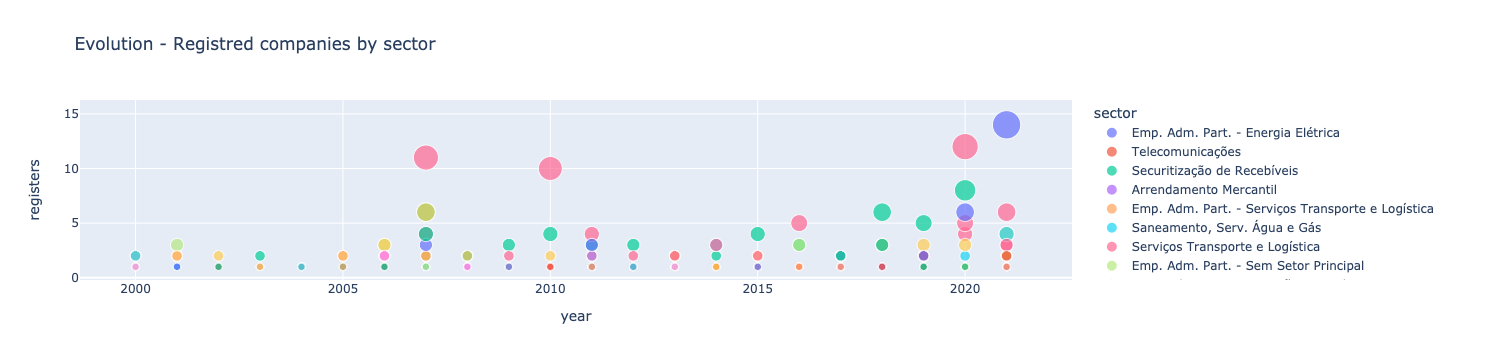

In [52]:
fig = px.scatter(pd_df_registers, x="year", y="registers", size="sector_size", color="sector", title="Evolution - Registred companies by sector")
fig.show()

In [44]:
df_cia_state = spark.sql("""
    SELECT 
        COUNT(f.*) as companies,
        l.state as state
    FROM fact_company_registration f
    JOIN dim_time t ON t.registration_date = f.registration_date
    JOIN dim_location l ON l.location_id = f.location_id
    WHERE t.year BETWEEN 2000 AND 2021
    GROUP BY state
""")

df_cia_state = df_cia_state.toPandas()
df_cia_state.head()

,companies,state
0,8,SC
1,1,PI
2,7,GO
3,1,TO
4,3,MT


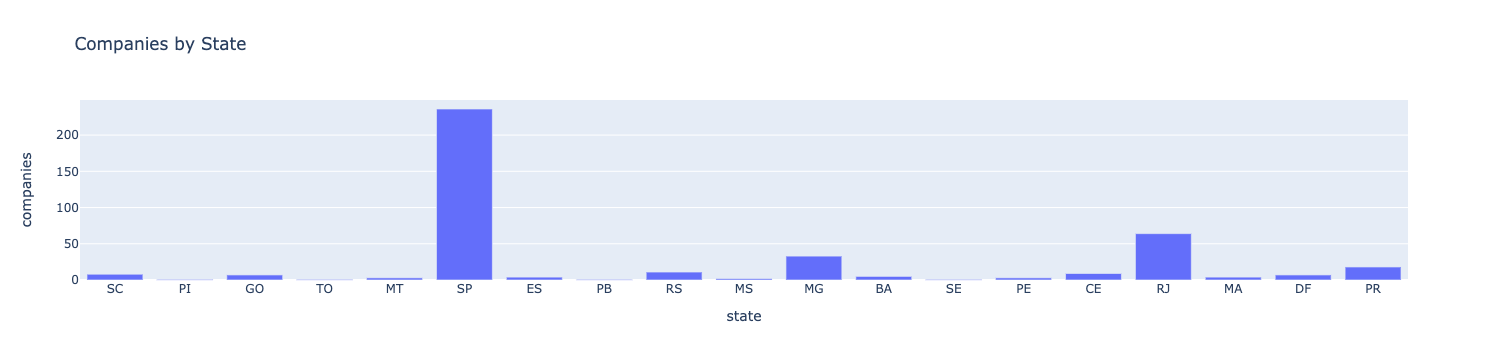

In [45]:
fig = px.bar(df_cia_state, x="state", y="companies", title="Companies by State")
fig.show()

In [49]:
df_cia_city_sp = spark.sql("""
    SELECT 
        COUNT(f.*) as companies,
        l.city
    FROM fact_company_registration f
    JOIN dim_time t ON t.registration_date = f.registration_date
    JOIN dim_location l ON l.location_id = f.location_id
    WHERE t.year BETWEEN 2000 AND 2021
        AND l.state = 'SP'
    GROUP BY city
""")

df_cia_city_sp = df_cia_city_sp.toPandas()
df_cia_city_sp.head()

,companies,city
0,1,SÃO JOAQUIM DA BARRA
1,3,MOGI DAS CRUZES
2,2,SALTO
3,1,GUARULHOS
4,1,BARRETOS


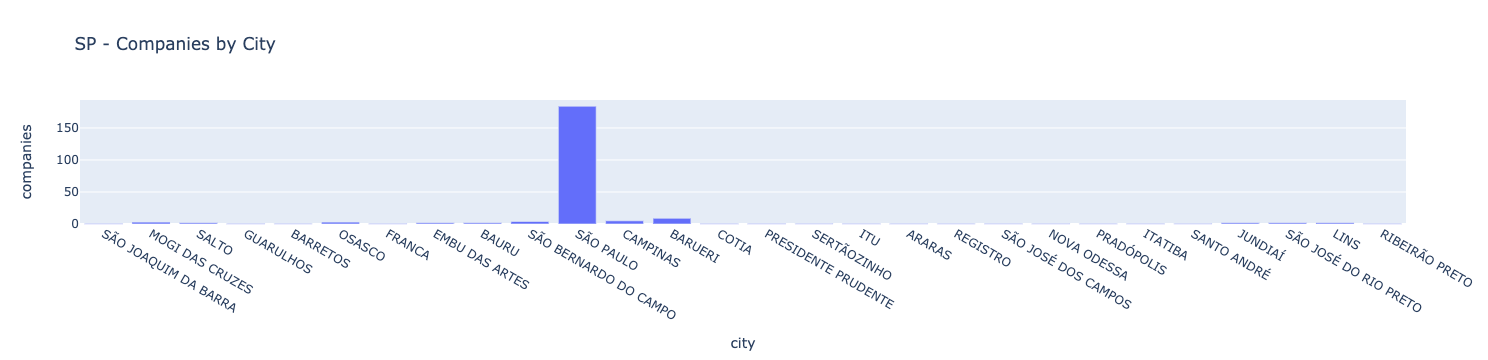

In [51]:
fig = px.bar(df_cia_city_sp, x="city", y="companies", title="SP - Companies by City")
fig.show()

#### 4.4 Data dictionary 

##### 4.4.1 fact_company_registration
|field              | type  | size | description              |
|:------------------|:------|:-----|:-------------------------|
| cvm_id            |int    |7     |CVM Code                  | 
| sector            |varchar|100   |Activity sector           |
| cnpj              |varchar|20    |Brazilian Company Document|
| registration_date |date   |10    |CVM registration date     |

##### 4.4.2 dim_date
|field               |type|size| description           |
|:-------------------|:---|:---|:----------------------|
| registration_date  |date|10  | CVM registration date |
| year               |int |4   | Year of date          |
| month              |int |2   | Month of date         |
| day                |int |2   | Day of date           |
| weekday            |int |1   | Weekday of date       |
| quarter            |int |1   | Quarter of date       |

##### 4.4.3 dim_location
|field            | type | size | description                |
|:----------------|:------|:----|:---------------------------|
| location_id     |int    |     | Auto generated location ID |
| state           |varchar| 2   | State of country           |
| city            |varchar| 100 | City of state              |
| nighborhood     |varchar| 100 | Neighborhood of city       |

##### 4.4.3 dim_company
|field            | type  |size | description                |
|:----------------|:------|:----|:---------------------------|
| cnpj            |varchar| 20  | Brazilian Company Document |
| company_name    |varchar| 100 | Company name in law        |
| business_name   |varchar| 100 | Company comercial name     |
| sector          |varchar| 100 | Company activity sector    |
| control_type    |varchar| 100 | Shareholding control type  |
| state           |varchar| 2   | State of country           |
| city            |varchar| 100 | City of state              |
| nighborhood     |varchar| 100 | Neighborhood of city       |

#### Step 5: Project Write Up

* The project was implemented using jupyter notebook, to easy visualization and colaboration, using PySpark to easly query file to validate data and create the final dataframes. The result data was saved on parquet files, that cam be moved to some cloud storage like S3 in future.

* The data should be updated directly, downloading file from [dados.cvm.gov.br](http://dados.cvm.gov.br/dataset/cia_aberta-cad) and save on `data` directory.

* How you would approach the problem differently under the following scenarios:
    * The data was increased by 100x: In this scenario, we can use Apache Spark on cloud to handle the data efectively.
    
    * The data populates a dashboard that must be updated on a daily basis by 7am every day: In this scenario, we can use Apache Airflow to create ETL scheduled DAGs.
    
    * The database needed to be accessed by 100+ people: In this scenario, we can use Redshift as main database to perform better and build some dashboards with BI tools.